In [2]:
from google.colab import files
uploaded = files.upload()

Saving household_power_consumption.txt to household_power_consumption.txt


In [3]:
import pandas as pd

file_name = "household_power_consumption.txt"  # mets ici le vrai nom

df = pd.read_csv(
    file_name,
    sep=";",                 # séparateur ;
    decimal=".",             # séparateur décimal .
    na_values="?",           # dans ce dataset, les valeurs manquantes sont "?"
)

In [ ]:
df.head()
# Date Time sont séparées, nous allon sles combiner, pour qu'elle soit plus adaptée au fonctionnalités predefinies de panda, qui fonctionne avec datetime comme index

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
# Combiner Date + Time en une seule colonne datetime
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S"
)

# Mettre datetime en index pour rapidité
df = df.set_index("datetime")

In [5]:
df.head()
# La combinaison à terminée

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
# Nous allons vérifier si tous les champs sont remplies
df.isna().sum()
# Remarque d'absence de 25979 valeurs pour quelques colonnes
# Nosu décidons de les supprimer car nous avons plus de 2M lignes, et 25979 fait 1% de la taille du Dataset

,0
Date,0
Time,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [7]:
num_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3",
]

# Nous supprimons les lignes où les mesures sont NaN
df = df.dropna(subset=num_cols)

df.isna().sum()
# Maintenant, nous n'avons aucune ligne avec valeur manquante


,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [8]:
len(df)
# 2 075 259 - 25 979 = 2 049 280

2049280

In [9]:
# Dans la phase de netoyyage, nous allons nous assurer que tous les champs chiffres sont numériques
num_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3",
]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df[num_cols].dtypes  # pour vérifier que c'est bien float64

,0
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


In [10]:
# Global_active_power est en kW mesuré chaque minute.
# Pour obtenir l'énergie consommée pendant chaque minute (en kWh),
# nous multiplions par la durée en heures : 1 minute = 1/60 heure → donc division par 60.
df["energy_kwh"] = df["Global_active_power"] / 60.0

In [11]:
#   - Pour les puissances et la tension, nous prenons la moyenne quotidienne.
#   - Pour les compteurs d'énergie (sub_metering_1/2/3) et energy_kwh, nous faisons la somme sur la journée.
# Création d'un nouveau Dataset Daily, qui match bien la forme de l'API consommée
daily = df.resample("D").agg({
    "Global_active_power": "mean",      # Puissance active moyenne (kW) par jour
    "Global_reactive_power": "mean",    # Puissance réactive moyenne (kVAR) par jour
    "Voltage": "mean",                  # Tension moyenne (V)
    "Global_intensity": "mean",         # Intensité moyenne (A)
    "Sub_metering_1": "sum",            # Énergie journalière (Wh) sur le compteur 1
    "Sub_metering_2": "sum",            # Énergie journalière (Wh) sur le compteur 2
    "Sub_metering_3": "sum",            # Énergie journalière (Wh) sur le compteur 3
    "energy_kwh": "sum"                 # Énergie totale journalière (kWh) = variable cible principale
})


In [12]:
daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_kwh
datetime,,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0,20.152933
2006-12-17,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,56.507667
2006-12-18,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,36.730433
2006-12-19,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,27.769900
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.0,2648.0,14063.0,37.095800


In [13]:
# 4) Nous renommons, juste comme bonne pratique la colonne datetime en date, car elle ne comporte pas le time
daily["date"] = daily.index
daily = daily.reset_index(drop=True)

In [14]:
len(daily)
print(daily.columns.tolist())
# 1442 lignes, pour notre objectif tracée, relation de la météo journalière et la type de jour ( week end, jours ferié , jour normal )

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'energy_kwh', 'date']


In [15]:
# Jour de la semaine (0 = lundi, 6 = dimanche)
daily["jour_semaine"] = daily["date"].dt.dayofweek

In [16]:
# Nom du jour (pour les graphiques)
daily["jour_nom"] = daily["date"].dt.day_name()

In [17]:
# Week-end : samedi (5) et dimanche (6)
daily["is_weekend"] = daily["jour_semaine"].isin([5, 6])

In [18]:
!pip install holidays
import pandas as pd
import holidays
# Jours fériés français (2006–2010)
fr_holidays = holidays.France(years=[2006, 2007, 2008, 2009, 2010])
daily["is_holiday"] = daily["date"].apply(lambda d: d in fr_holidays)

In [19]:
daily[["date", "jour_nom", "is_weekend", "is_holiday", "energy_kwh"]].head(15)
# Maintenant, nous avons pour chaque ligne, est ce que c'est un week end ?
# ou c'est un jours ferié,
# les jours normaux sont les jours dont weekend = false et holyday = false


,date,jour_nom,is_weekend,is_holiday,energy_kwh
0,2006-12-16,Saturday,True,False,20.152933
1,2006-12-17,Sunday,True,False,56.507667
2,2006-12-18,Monday,False,False,36.730433
3,2006-12-19,Tuesday,False,False,27.769900
4,2006-12-20,Wednesday,False,False,37.095800
5,2006-12-21,Thursday,False,False,28.610400
6,2006-12-22,Friday,False,False,39.022300
7,2006-12-23,Saturday,True,False,79.556433
8,2006-12-24,Sunday,True,False,42.500200
9,2006-12-25,Monday,False,True,45.718667


In [20]:
daily.nlargest(10, "energy_kwh")[["date", "jour_nom", "is_weekend", "is_holiday", "energy_kwh"]]
# Dejà une remarque avant même d'aller à la météo, les TOP 1 sont generalement des week ends en hiver

,date,jour_nom,is_weekend,is_holiday,energy_kwh
7,2006-12-23,Saturday,True,False,79.556433
49,2007-02-03,Saturday,True,False,67.162033
10,2006-12-26,Tuesday,False,False,65.568500
64,2007-02-18,Sunday,True,False,63.829367
50,2007-02-04,Sunday,True,False,59.932333
57,2007-02-11,Sunday,True,False,59.520467
105,2007-03-31,Saturday,True,False,58.491833
15,2006-12-31,Sunday,True,False,58.236600
85,2007-03-11,Sunday,True,False,58.010600
36,2007-01-21,Sunday,True,False,56.787700


In [21]:
# Mois numérique (1 = janvier, ..., 12 = décembre)
daily["mois"] = daily["date"].dt.month

# Nom du mois (Janvier, Février, ...)
daily["mois_nom"] = daily["date"].dt.month_name()

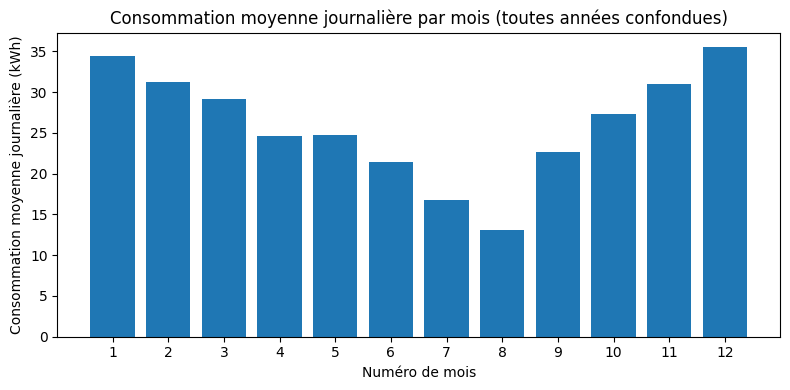

In [22]:
# Affichage d'un graphe pour indiquer la relation entre le mois ( froid ou chaud ) et la consommation
import matplotlib.pyplot as plt

moyenne_par_mois = (
    daily.groupby("mois")[["energy_kwh"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 4))
plt.bar(moyenne_par_mois["mois"], moyenne_par_mois["energy_kwh"])
plt.xticks(range(1, 13))
plt.xlabel("Numéro de mois")
plt.ylabel("Consommation moyenne journalière (kWh)")
plt.title("Consommation moyenne journalière par mois (toutes années confondues)")
plt.tight_layout()
plt.show()

In [23]:
import requests
import pandas as pd


# Période couverte par vos données, pour passer à l'API, en relation avec le tableau comme plage
date_min = daily["date"].min().strftime("%Y-%m-%d")
date_max = daily["date"].max().strftime("%Y-%m-%d")

# Coordonnées de Sceaux (France) selons le site web https://www.gps-longitude-latitude.net/
lat, lon = 48.78, 2.29
# Liste des données que nous voulons
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": lat,
    "longitude": lon,
    "start_date": date_min,
    "end_date": date_max,
    "daily": [
        "temperature_2m_mean",
        "temperature_2m_min",
        "temperature_2m_max",
        "precipitation_sum",
        "daylight_duration",
        "sunshine_duration",
    ],
    "timezone": "Europe/Paris",
}
# Consommation de l'API
resp = requests.get(url, params=params)
resp.raise_for_status()
data = resp.json()

# Création du DataFrame météo,
weather = pd.DataFrame(data["daily"])
# Convertir en Date
weather["date"] = pd.to_datetime(weather["time"])
# Suppression de colone time, elle est imposé par l'API, obligé de la notoyé ici
weather = weather.drop(columns=["time"])

weather.head()

,temperature_2m_mean,temperature_2m_min,temperature_2m_max,precipitation_sum,daylight_duration,sunshine_duration,date
0,6.2,3.3,8.4,3.8,29825.21,0.00,2006-12-16
1,3.0,-0.2,7.1,0.0,29797.73,19535.07,2006-12-17
2,3.1,1.2,5.2,0.9,29775.72,7489.45,2006-12-18
3,1.8,0.6,4.2,0.0,29759.19,24686.46,2006-12-19
4,1.2,-0.8,4.8,0.0,29748.15,24821.37,2006-12-20


In [24]:
# Etape importante, le Merge entre API et Dataset, cette ligne doit petre executée une seule fois sinon nous allons avoir 2 colonnes
# et pd change le nom des colonnes automatiquement, avec _x et _y
daily = daily.merge(weather, on="date", how="left")

In [27]:
# Vérification du forme du tableau
daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_kwh,date,jour_semaine,...,is_weekend,is_holiday,mois,mois_nom,temperature_2m_mean,temperature_2m_min,temperature_2m_max,precipitation_sum,daylight_duration,sunshine_duration
0,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0,20.152933,2006-12-16,5,...,True,False,12,December,6.2,3.3,8.4,3.8,29825.21,0.00
1,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,56.507667,2006-12-17,6,...,True,False,12,December,3.0,-0.2,7.1,0.0,29797.73,19535.07
2,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,36.730433,2006-12-18,0,...,False,False,12,December,3.1,1.2,5.2,0.9,29775.72,7489.45
3,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,27.769900,2006-12-19,1,...,False,False,12,December,1.8,0.6,4.2,0.0,29759.19,24686.46
4,1.545658,0.111804,242.308062,6.467361,0.0,2648.0,14063.0,37.095800,2006-12-20,2,...,False,False,12,December,1.2,-0.8,4.8,0.0,29748.15,24821.37


In [28]:
# Convertir le nombre de secondes entre lever et coucher de solein en heures
daily["daylight_hours"] = daily["daylight_duration"] / 3600.0

In [29]:
daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_kwh,date,jour_semaine,...,is_holiday,mois,mois_nom,temperature_2m_mean,temperature_2m_min,temperature_2m_max,precipitation_sum,daylight_duration,sunshine_duration,daylight_hours
0,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0,20.152933,2006-12-16,5,...,False,12,December,6.2,3.3,8.4,3.8,29825.21,0.00,8.284781
1,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,56.507667,2006-12-17,6,...,False,12,December,3.0,-0.2,7.1,0.0,29797.73,19535.07,8.277147
2,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,36.730433,2006-12-18,0,...,False,12,December,3.1,1.2,5.2,0.9,29775.72,7489.45,8.271033
3,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,27.769900,2006-12-19,1,...,False,12,December,1.8,0.6,4.2,0.0,29759.19,24686.46,8.266442
4,1.545658,0.111804,242.308062,6.467361,0.0,2648.0,14063.0,37.095800,2006-12-20,2,...,False,12,December,1.2,-0.8,4.8,0.0,29748.15,24821.37,8.263375


/tmp/ipython-input-3834680876.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily.groupby("temp_bin")["energy_kwh"]


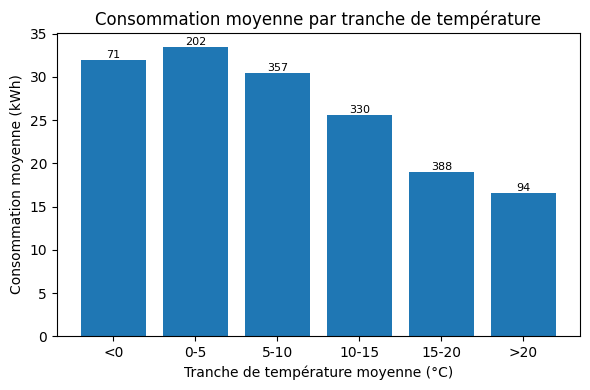

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Tranches de température
bins = [-10, 0, 5, 10, 15, 20, 30]
labels = ["<0", "0-5", "5-10", "10-15", "15-20", ">20"]
daily["temp_bin"] = pd.cut(daily["temperature_2m_mean"], bins=bins, labels=labels, include_lowest=True)

# Moyenne + nombre de jours par tranche
stats_par_bin = (
    daily.groupby("temp_bin")["energy_kwh"]
    .agg(["mean", "count"])
    .reset_index()
)

plt.figure(figsize=(6, 4))
bars = plt.bar(stats_par_bin["temp_bin"], stats_par_bin["mean"])

plt.xlabel("Tranche de température moyenne (°C)")
plt.ylabel("Consommation moyenne (kWh)")
plt.title("Consommation moyenne par tranche de température")

# Ajouter le nombre d'éléments au-dessus de chaque barre
for bar, n in zip(bars, stats_par_bin["count"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(n),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.show()
# ça nous aide encore à créer avoir une idée de relation entre "Fait froid" et "consommation".
# nous avons ajouté le nombre audesus de chaque barre juste oiyr argumenter Pk la consommation
# dans la situation <0 est plus petite que entre 0 et 5

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
features = [
    "temperature_2m_mean",
    "temperature_2m_min",
    "temperature_2m_max",
    "precipitation_sum",
    "daylight_hours",
    "sunshine_duration",
    "jour_semaine",
    "is_weekend",
    "is_holiday",
    "mois",
]

X = daily[features].copy()
y = daily["energy_kwh"]

# Séparation train / test (sans mélanger, pour garder l'ordre temporel)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Modèle
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE (kWh) :", round(rmse, 2))
print("R²         :", round(r2, 3))

# Nous remarquons que notre prédiction n'est pas performante
# Nosu allons essayer d'ajouter d'autre variables à notre DataSet
# Seuil confort pour avoir une relation linéaire entre Difference et consommation
# Traitement cyclique du mois 1 et 12
# Consommation le même jour il ya uen semaine ( pour capter les habitudes )

RMSE (kWh) : 7.31
R²         : 0.23


In [32]:
import numpy as np

# --- Degrés Jours Unifiés (DJU) - seuil 18°C ---
seuil_confort = 18
daily["DJU"] = (seuil_confort - daily["temperature_2m_mean"]).clip(lower=0)

# --- Variables cycliques du mois (décembre proche de janvier) ---
daily["sin_mois"] = np.sin(2 * np.pi * daily["mois"] / 12)
daily["cos_mois"] = np.cos(2 * np.pi * daily["mois"] / 12)

# --- Lag 7 : consommation le même jour de la semaine dernière ---
daily["energy_kwh_lag7"] = daily["energy_kwh"].shift(7)

# Supprimer les lignes avec NaN (les 7 premiers jours n'ont pas de lag7)
daily = daily.dropna(subset=["energy_kwh_lag7"]).copy()

In [33]:
features = [
    "DJU",
    "daylight_hours",
    "sin_mois",
    "cos_mois",
    "is_weekend",
    "is_holiday",
    "energy_kwh_lag7",
]

X = daily[features].copy()
y = daily["energy_kwh"]

# Séparation Train / Test (shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Évaluation
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE (kWh) :", round(rmse, 2))
print("R²         :", round(r2, 3))

RMSE (kWh) : 7.5
R²         : 0.191


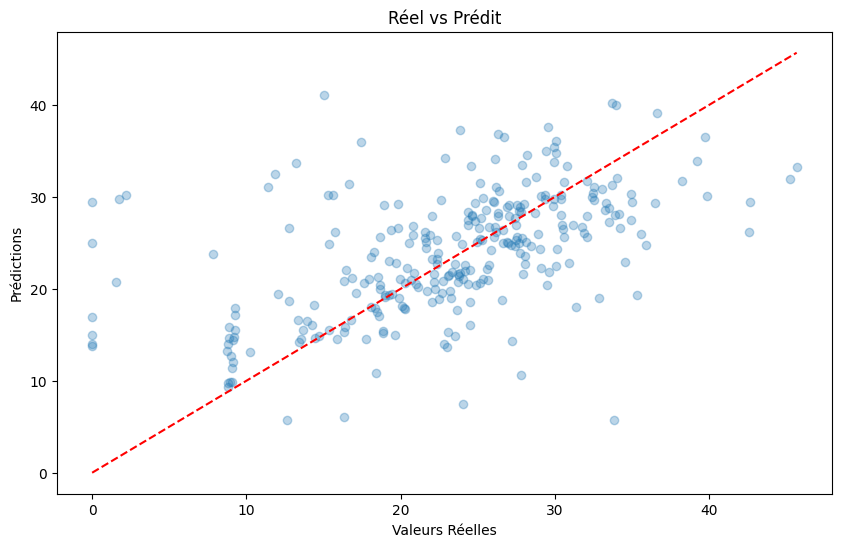

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Réel vs Prédit')
plt.show()
# Les valeurs reels ne sont pas vraiment lnéaire, ce qui montre qu'il ya autres variables en relation avec la consommation
# Nous allons essayer d'eliminer les lignes avec une valeurs de consommation < 4Kwh
# La moyenne de consommation en france est 13Kwh

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Filtrer : garder seulement les jours où energy_kwh > 0.5 ---
mask = daily["energy_kwh"] > 4
daily_filtre = daily.loc[mask].copy()

print("Nombre de jours avant filtre :", len(daily))
print("Nombre de jours après filtre (energy_kwh > 4) :", len(daily_filtre))

# --- X et y sur le jeu filtré ---
features = [
    "DJU",
    "daylight_hours",
    "sin_mois",
    "cos_mois",
    "is_weekend",
    "is_holiday",
    "energy_kwh_lag7"
]

X_f = daily_filtre[features].copy()
y_f = daily_filtre["energy_kwh"]

# --- Train / Test (ordre temporel) ---
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_f, y_f, test_size=0.2, shuffle=False
)
# --- Entraînement ---
rf_f = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_f.fit(X_train_f, y_train_f)

# --- Prédiction ---
y_pred_f = rf_f.predict(X_test_f)

# --- RECALCUL DES MÉTRIQUES (L'étape manquante) ---
rmse_f = np.sqrt(mean_squared_error(y_test_f, y_pred_f))
mae_f = mean_absolute_error(y_test_f, y_pred_f)
r2_f = r2_score(y_test_f, y_pred_f)

# --- Affichage ---
print("--- Résultats après ajout de Lag1 ---")
print("RMSE (kWh) :", round(rmse_f, 2))
print("MAE (kWh)  :", round(mae_f, 2))
print("R²         :", round(r2_f, 3))

# Amélioration du R² et du RMSE

Nombre de jours avant filtre : 1435
Nombre de jours après filtre (energy_kwh > 4) : 1421
--- Résultats après ajout de Lag1 ---
RMSE (kWh) : 6.6
MAE (kWh)  : 4.78
R²         : 0.243


In [38]:
import pandas as pd

# 1. On crée un DataFrame spécifique pour les résultats du test
# On utilise .index pour garder la correspondance avec X_test_f
df_res = X_test_f.copy()
df_res['y_test'] = y_test_f.values
df_res['y_pred'] = y_pred_f
df_res['erreur'] = df_res['y_test'] - df_res['y_pred']
df_res['erreur_abs'] = df_res['erreur'].abs()

# 2. On trie par l'erreur absolue pour voir les plus gros écarts
top_20_err = df_res.sort_values(by='erreur_abs', ascending=False).head(20)

# 3. Affichage propre (on retire erreur_abs de l'affichage pour plus de clarté)
print("Top 20 des plus grosses erreurs (Jeu Filtré > 4 kWh) :")
print(top_20_err.drop(columns=['erreur_abs']).to_string())

Top 20 des plus grosses erreurs (Jeu Filtré > 4 kWh) :
       DJU  daylight_hours      sin_mois      cos_mois  is_weekend  is_holiday  energy_kwh_lag7     y_test     y_pred     erreur
1350   0.0       13.722336 -8.660254e-01 -5.000000e-01       False       False         0.000000  33.844167   5.150841  28.693326
1436  12.2        8.936978 -5.000000e-01  8.660254e-01        True       False        33.973200  15.015167  43.007026 -27.991859
1174  14.3       11.194506  1.000000e+00  6.123234e-17       False       False        31.336733  11.381333  31.255396 -19.874063
1176  15.7       11.312433  1.000000e+00  6.123234e-17        True       False        29.417600  13.245200  32.839240 -19.594040
1401  11.4       10.740428 -8.660254e-01  5.000000e-01        True       False        33.315067  17.456367  35.817848 -18.361481
1170  10.0       10.957164  8.660254e-01  5.000000e-01        True       False        45.671900  11.861100  30.190160 -18.329060
1419   3.1        9.742783 -5.000000e-01  

In [39]:
# Nous proposons d'ajouter autre critères
import requests
import pandas as pd

# Même période et lieu que ta première requête
date_min = daily["date"].min().strftime("%Y-%m-%d")
date_max = daily["date"].max().strftime("%Y-%m-%d")
lat, lon = 48.78, 2.29

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": lat,
    "longitude": lon,
    "start_date": date_min,
    "end_date": date_max,
    "daily": ["relative_humidity_2m_mean"],
    "timezone": "Europe/Paris",
}

resp = requests.get(url, params=params)
resp.raise_for_status()
data = resp.json()

# DataFrame : date + humidité
humidity_df = pd.DataFrame(data["daily"])
humidity_df["date"] = pd.to_datetime(humidity_df["time"])
humidity_df = humidity_df[["date", "relative_humidity_2m_mean"]].rename(
    columns={"relative_humidity_2m_mean": "humidity_mean"}
)
humidity_df.head()

,date,humidity_mean
0,2006-12-23,91
1,2006-12-24,92
2,2006-12-25,96
3,2006-12-26,93
4,2006-12-27,83


In [40]:
# Fusion sur la colonne date (garder toutes les lignes de daily)
daily = daily.merge(humidity_df, on="date", how="left")
daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_kwh,date,jour_semaine,...,precipitation_sum,daylight_duration,sunshine_duration,daylight_hours,temp_bin,DJU,sin_mois,cos_mois,energy_kwh_lag7,humidity_mean
0,3.314851,0.153799,240.136076,14.028056,2669.0,425.0,14726.0,79.556433,2006-12-23,5,...,0.0,29748.00,15857.04,8.263333,0-5,16.4,-2.449294e-16,1.0,20.152933,91
1,1.770842,0.104097,241.687437,7.640417,1703.0,5082.0,6891.0,42.500200,2006-12-24,6,...,0.0,29758.94,0.00,8.266372,0-5,16.6,-2.449294e-16,1.0,56.507667,92
2,1.904944,0.166861,243.399931,7.951528,6620.0,1962.0,5795.0,45.718667,2006-12-25,0,...,0.0,29775.36,0.00,8.270933,0-5,16.7,-2.449294e-16,1.0,36.730433,96
3,2.732021,0.114654,241.625438,11.347917,1086.0,2533.0,14979.0,65.568500,2006-12-26,1,...,0.0,29797.24,795.79,8.277011,0-5,17.5,-2.449294e-16,1.0,27.769900,93
4,1.061639,0.124237,243.767361,4.517500,0.0,314.0,6976.0,25.479333,2006-12-27,2,...,0.0,29824.57,326.34,8.284603,0-5,17.8,-2.449294e-16,1.0,37.095800,83


In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mask = (daily["energy_kwh"] > 4) & (daily["energy_kwh"] <= 35)
daily_filtre = daily.loc[mask].copy()
daily["energy_kwh_lag1"] = daily["energy_kwh"].shift(1)
features = [
    "DJU",
    "daylight_hours",
    "sin_mois",
    "cos_mois",
    "is_weekend",
    "is_holiday",
    "energy_kwh_lag7",
    "energy_kwh_lag1",
]

X_f = daily_filtre[features].copy()
y_f = daily_filtre["energy_kwh"]

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_f, y_f, test_size=0.1, shuffle=False
)

rf_f = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_f.fit(X_train_f, y_train_f)

y_pred_f = rf_f.predict(X_test_f)
rmse_f = np.sqrt(mean_squared_error(y_test_f, y_pred_f))
mae_f = mean_absolute_error(y_test_f, y_pred_f)
r2_f = r2_score(y_test_f, y_pred_f)

print("Nombre de jours (energy_kwh > 4) :", len(daily_filtre))
print("RMSE (kWh) :", round(rmse_f, 2))
print("MAE (kWh)  :", round(mae_f, 2))
print("R²         :", round(r2_f, 3))
# Amélioration du R² et du RMSE

Nombre de jours (energy_kwh > 4) : 1197
RMSE (kWh) : 4.85
MAE (kWh)  : 3.68
R²         : 0.587
